# Analyze Results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from pathlib import Path
import pickle

In [2]:
plt.rcParams["figure.figsize"] = (20, 8)
#plt.style.use('dark_background')

In [3]:
source_folder = Path("../results/dissertation/")
EXPERIMENTS_FILE = source_folder / Path("experiments.pkl")
EVALUATIONS_FILE = source_folder / Path("evaluations.pkl")

In [4]:
experiments = pickle.load(EXPERIMENTS_FILE.open('rb'))
evaluations = pickle.load(EVALUATIONS_FILE.open('rb'))

In [5]:
metrics = evaluations["metrics"].iloc[0]
values = evaluations["vals"]
for m, metric in enumerate(metrics):
    evaluations[metric] = values.apply(lambda v: v[m])

In [6]:
experiments_df = experiments.attributes.apply(pd.Series)
experiments_df['id'] = experiments.id
edf = experiments_df

In [7]:
def filter_exp(filters):
    return evaluations[evaluations.experiment_id.isin(experiments_df[filters].id)]

### Colors

In [8]:
from matplotlib import cm

blue_categorical = [  # https://spectrum.adobe.com/page/color-for-data-visualization/
    "#00c0c7",
    "#5144d3",
    "#da3490",
    "#9089fa"
]


def base_blue(a=1.0):
    return (0, 0, 1.0, a)

def base_red(a=1.0):
    return (1.0, 0, 0, a)

DATAGOSSIP_COLOR = {
    "balanced": blue_categorical[0],
    "imbalanced": blue_categorical[1]
}
BASELINE_COLOR = {
    "balanced": "#e8871a",
    "imbalanced": base_red()
}

### Plot Function

In [9]:
plt.rcParams.update({'font.size': 22})


def get_color(df: pd.DataFrame):
    df = df.iloc[0]
    if df.datagossip:
        return DATAGOSSIP_COLOR["imbalanced" if df.imbalanced else "balanced"]
    return BASELINE_COLOR["imbalanced" if df.imbalanced else "balanced"]


def get_linestyle(df: pd.DataFrame):
    df = df.iloc[0]
    if df.instance_selector == InstanceSelectorChooser.HARDEXAMPLEMINING:
        return "dashed"
    return "solid"


def cut_plot(df:pd.DataFrame, cuts):
    df = df.iloc[0]
    if df.datagossip:
        return cuts[0]
    return cuts[1]


def plot_experiment(filters, metric, compare, groupby="step", split=False, fig=None, axs=None, cuts=None, legend=True, colors_custom=None):
    compare_vals = edf[filters][compare].unique()
    
    if split and axs is None:
        fig, axs = plt.subplots(1, 2)
    elif not split and axs is None:
        fig, axs = plt.subplots(1, 1)
    
    for i, dataset in enumerate(edf[filters]["dataset"].unique()):
        if split:
            ax = axs[i]
        else:
            ax = axs
        
        if dataset == "fashionmnist":
            ax.set_ylim(0.4, 0.9)
            
        for o, comp in enumerate(compare_vals):
            tmp_filters = filters & (edf[compare] == comp)
            if split:
                tmp_filters = tmp_filters & (edf["dataset"] == dataset)
            
            filtered = edf[tmp_filters]
            results = filter_exp(tmp_filters)
            grouped = results.groupby(groupby)
            
            if colors_custom:
                color = colors_custom[o]
            else:
                color = get_color(filtered)
            
            y_avg = grouped[metric].mean()
            y_std = grouped[metric].std()
            x = y_avg.index.sort_values()
            
            if cuts is not None:
                cut = cut_plot(edf[tmp_filters], cuts)
                y_avg = y_avg[:cut]
                y_std = y_std[:cut]
                x = x[:cut]

            ax.plot(y_avg, color=color, label=f"{compare} = {comp}", linestyle=get_linestyle(filtered))
            ax.set_title(f"Dataset: {dataset}")
            

            y1 = y_avg - y_std
            y2 = y_avg + y_std
            ax.fill_between(x, y1, y2, alpha=0.1, color=color)

            ax.set_xlabel("Time in seconds")
            if i == 0:
                ax.set_ylabel("Test accuracy")
    if legend:
        fig.legend(loc="upper center", ncol=len(compare_vals), bbox_to_anchor=(0.5, 1.05, 0., 0.))
    return fig, axs
    

# Paper Plots

In [10]:
from datagossip.instance_selector import InstanceSelectorChooser

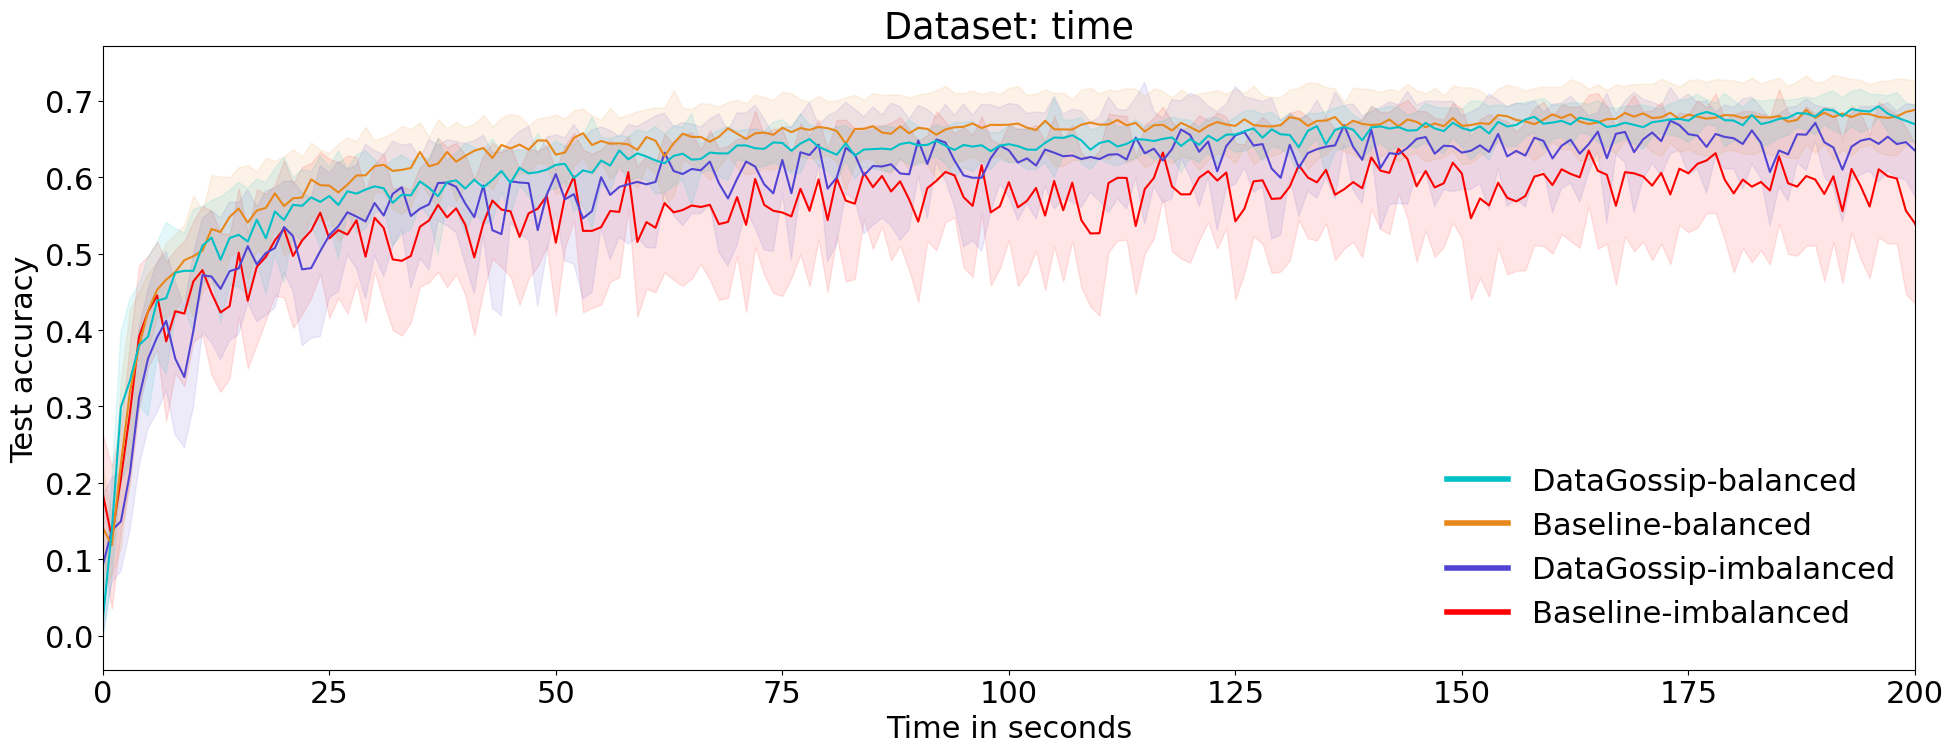

In [11]:
fig, axs = plot_experiment((edf.imbalanced == True) & (edf.k == 5) & (edf.instance_selector == InstanceSelectorChooser.ACTIVEBIAS) & (edf.remote_train_frequency == 4), "acc", "datagossip", "process_time", split=False, cuts=[350, 350], legend=False)
fig, axs = plot_experiment((edf.imbalanced == False) & (edf.k == 5) & (edf.instance_selector == InstanceSelectorChooser.ACTIVEBIAS) & (edf.remote_train_frequency == 4), "acc", "datagossip", "process_time", split=False, fig=fig, axs=axs, cuts=[350, 350], legend=False)


custom_lines = [Line2D([0], [0], color=DATAGOSSIP_COLOR["balanced"], lw=4, clip_on=False),
                Line2D([0], [0], color=BASELINE_COLOR["balanced"], lw=4, clip_on=False),
                Line2D([0], [0], color=DATAGOSSIP_COLOR["imbalanced"], lw=4, clip_on=False),
                Line2D([0], [0], color=BASELINE_COLOR["imbalanced"], lw=4, clip_on=False)]

custom_labels = ["DataGossip-balanced", "Baseline-balanced", "DataGossip-imbalanced", "Baseline-imbalanced"]

plt.xlim(0, 200)
fig.legend(custom_lines, custom_labels, loc="lower right", ncol=1, bbox_to_anchor=[0.973,0.15,0,0], framealpha=0)
fig.tight_layout()
fig.savefig("../plots/datagossip_on_off-time.svg", format="svg", bbox_inches='tight', transparent=True)

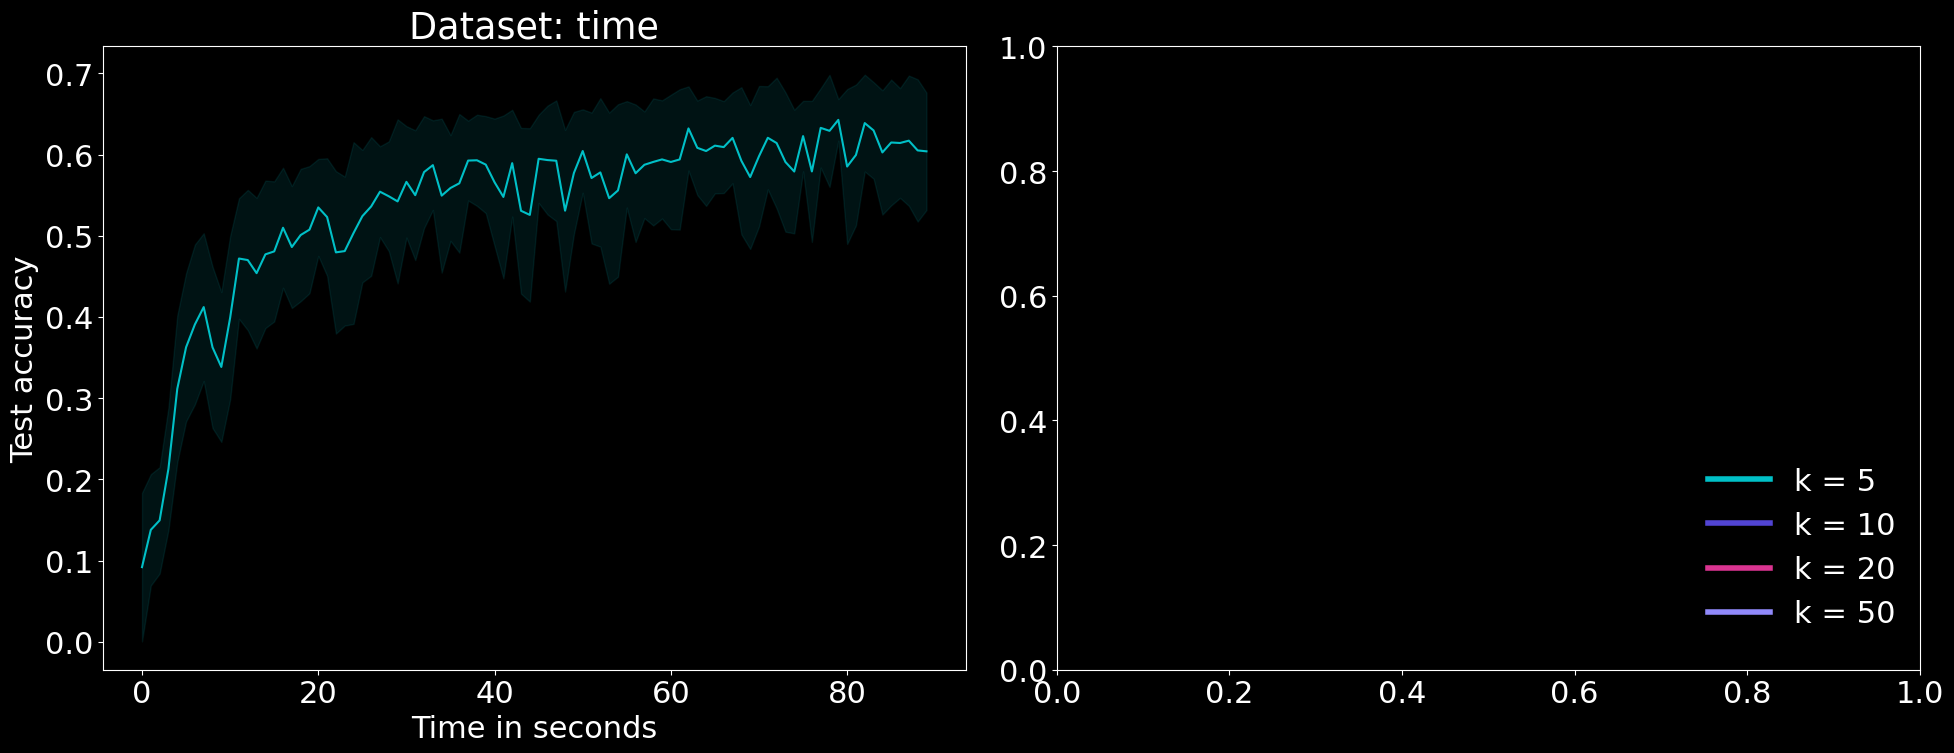

In [14]:
colors_custom = blue_categorical
fig, _ = plot_experiment((edf.datagossip == True) & (edf.instance_selector == InstanceSelectorChooser.ACTIVEBIAS) & (edf.remote_train_frequency == 4) & (edf.imbalanced == True), "acc", "k", "process_time", split=True, colors_custom=colors_custom, legend=False, cuts=[90])

custom_lines = [Line2D([0], [0], color=colors_custom[0], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[1], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[2], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[3], lw=4, clip_on=False)]

custom_labels = [f"k = {k}" for k in [5, 10, 20, 50]]
fig.legend(custom_lines, custom_labels, loc="lower right", ncol=1, bbox_to_anchor=[0.973,0.15,0,0], framealpha=0)
fig.tight_layout()
fig.savefig("../plots/amount-k-dark.png", format="png", bbox_inches='tight', transparent=True)

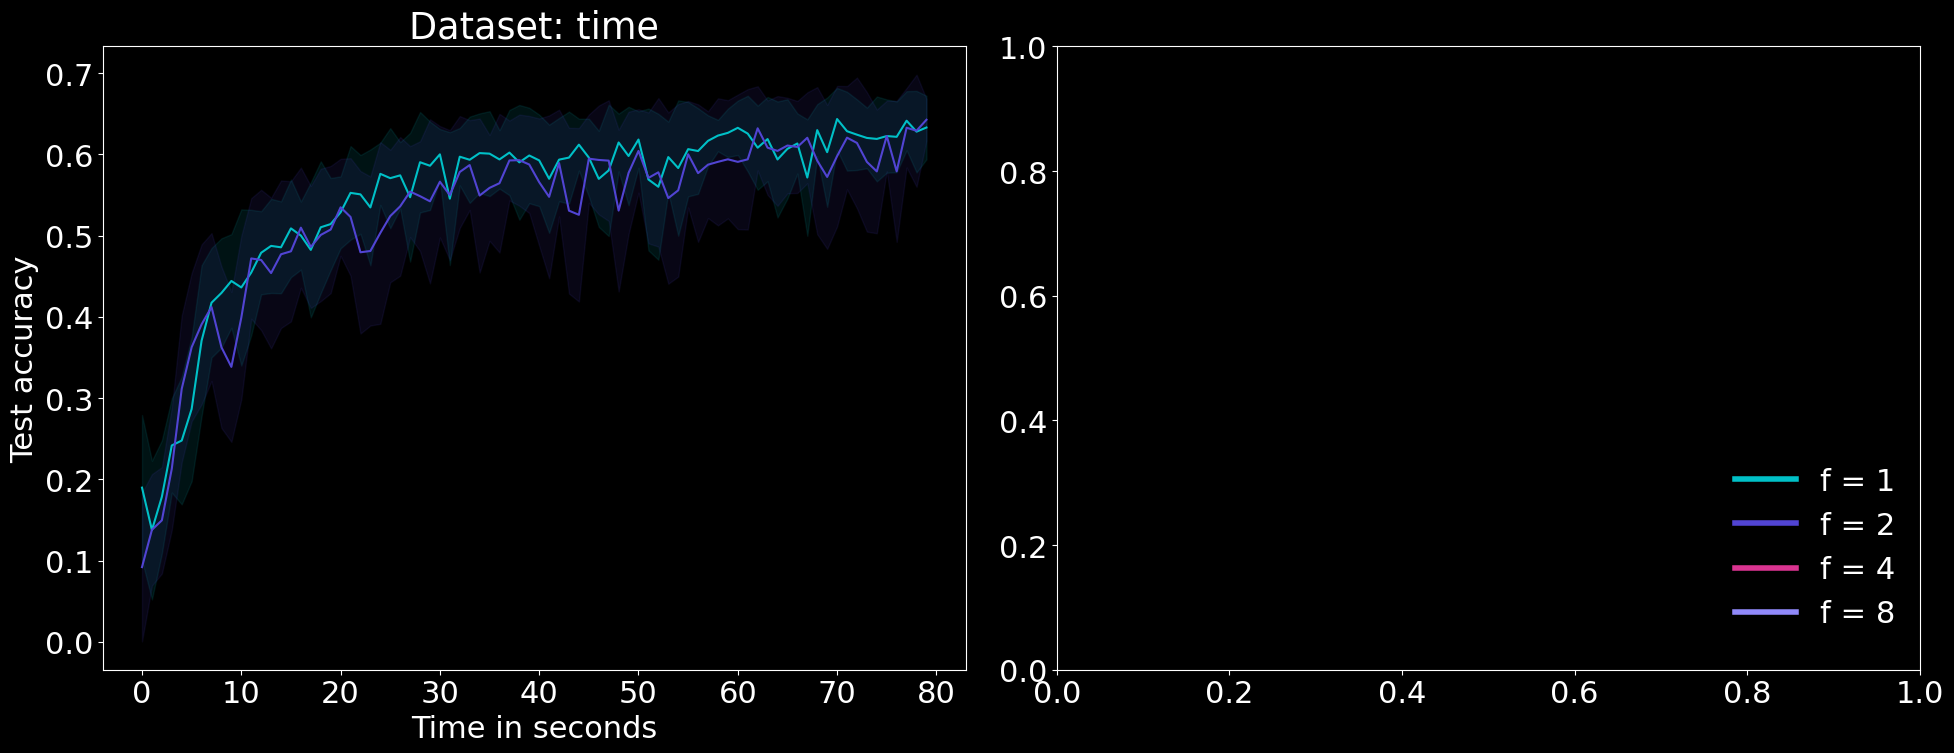

In [15]:
colors_custom = blue_categorical
fig, _ = plot_experiment((edf.datagossip == True) & (edf.instance_selector == InstanceSelectorChooser.ACTIVEBIAS) & (edf.imbalanced == True), "acc", "remote_train_frequency", "process_time", split=True, colors_custom=colors_custom, legend=False, cuts=[80])

custom_lines = [Line2D([0], [0], color=colors_custom[0], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[1], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[2], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[3], lw=4, clip_on=False)]

custom_labels = [f"f = {k}" for k in [1, 2, 4, 8]]
fig.legend(custom_lines, custom_labels, loc="lower right", ncol=1, bbox_to_anchor=[0.973,0.15,0,0], framealpha=0)
fig.tight_layout()
fig.savefig("../plots/remote-train-frequency-dark.png", format="png", bbox_inches='tight', transparent=True)

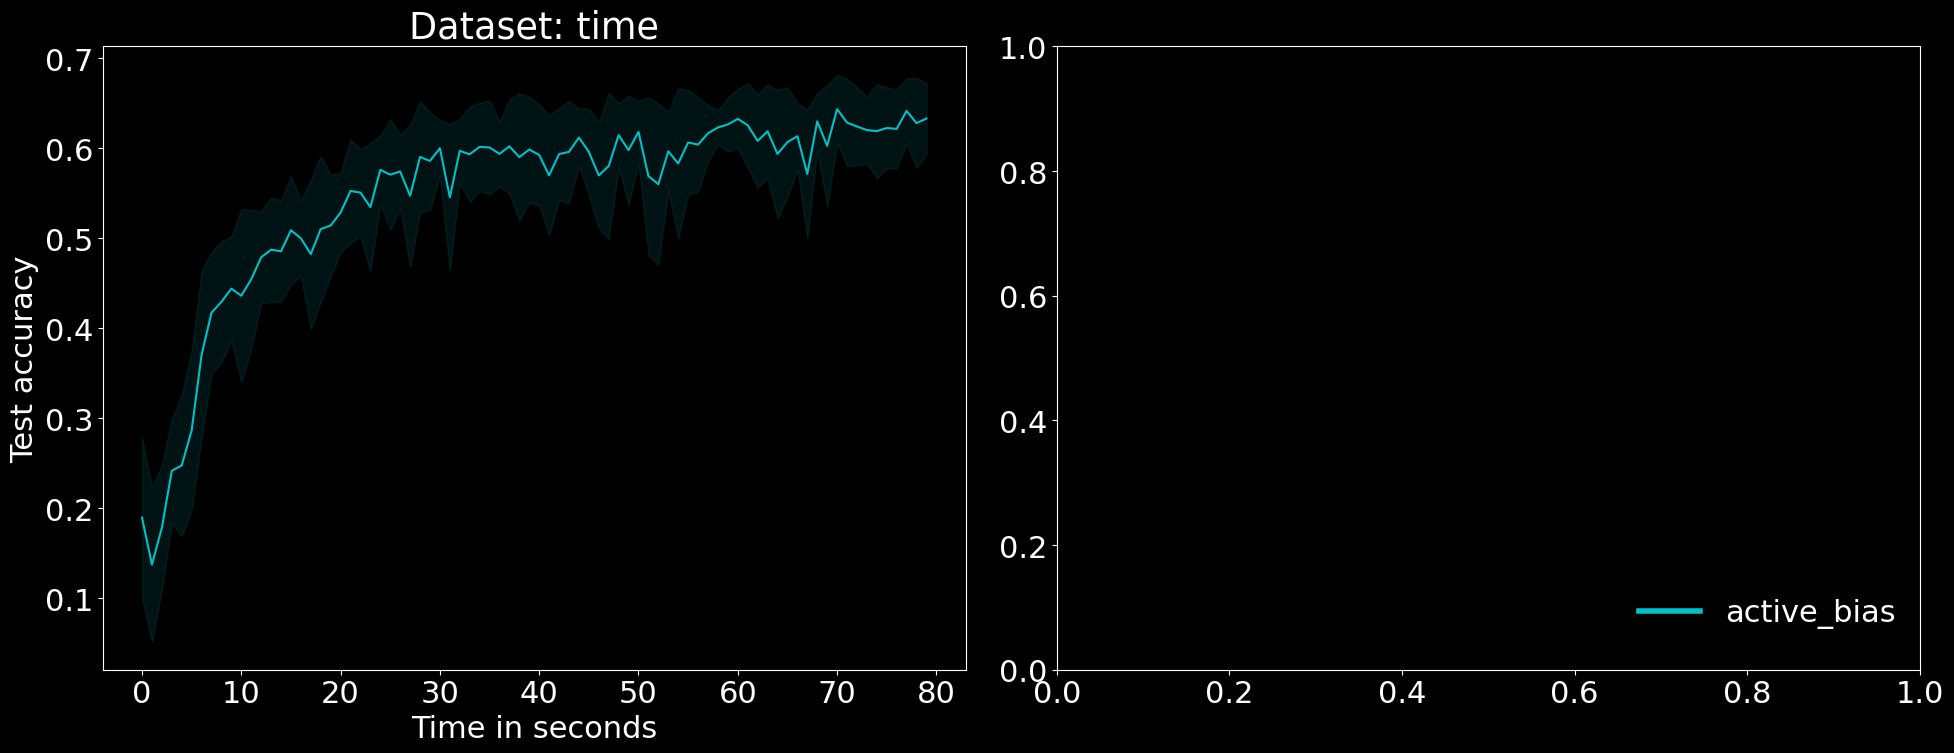

In [16]:
colors_custom = blue_categorical
fig, _ = plot_experiment((edf.datagossip == True) & (edf.k == 5) & (edf.remote_train_frequency == 1) & (edf.imbalanced == True), "acc", "instance_selector", "process_time", split=True, colors_custom=colors_custom, legend=False, cuts=[80])

custom_lines = [Line2D([0], [0], color=colors_custom[0], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[1], lw=4, clip_on=False, linestyle="dashed"),
                Line2D([0], [0], color=colors_custom[2], lw=4, clip_on=False),
                Line2D([0], [0], color=colors_custom[3], lw=4, clip_on=False)]

custom_labels = edf[(edf.datagossip == True) & (edf.k == 5) & (edf.remote_train_frequency == 1)].instance_selector.unique()
fig.legend(custom_lines, custom_labels, loc="lower right", ncol=1, bbox_to_anchor=[0.973,0.15,0,0], framealpha=0)
fig.tight_layout()
fig.savefig("../plots/instance-selector-dark.png", format="png", bbox_inches='tight', transparent=True)